In [3]:
import csv
import pandas as pd

In [4]:
def read_conversation(filename, delimiter=','):
    """_summary_

    Args:
        filename (csv): _description_
        delimiter (str, optional): _description_. Defaults to ','.

    Returns:
        list: _description_
    """

    conversation = []
    with open(filename, 'r', encoding='utf8') as file:
        csv_reader = csv.reader(file, delimiter = delimiter)
        
        turn = 0 
        for idx, csv_line in enumerate(csv_reader):
            
            if idx != 0 and conversation[turn-1]['user_id'] == csv_line[1] and conversation[turn-1]['reply_id'] == csv_line[3]:
                msg_join = f"{conversation[turn-1]['message_text']}. {csv_line[2]}"
                list_id = conversation[turn-1]['id'] + [csv_line[0]]
                conversation[turn-1]['id'] = list_id
                conversation[turn-1]['message_text'] = msg_join

            else:
                id = csv_line[0]
                user_id = csv_line[1]
                message_text = csv_line[2]
                reply_id = csv_line[3]
                turn +=1

                conversation.append({
                    'id': [id],
                    'user_id': user_id,
                    'message_text': message_text,
                    'reply_id': reply_id
                })


    return conversation

In [5]:
a = (read_conversation('a.csv'))
print('\n',a)


 [{'id': ['0'], 'user_id': '10', 'message_text': 'olá', 'reply_id': 'None'}, {'id': ['1'], 'user_id': '11', 'message_text': 'Olá amigo', 'reply_id': '0'}, {'id': ['2'], 'user_id': '12', 'message_text': ' Olá a todos', 'reply_id': 'None'}, {'id': ['3'], 'user_id': '11', 'message_text': ' Como vão', 'reply_id': 'None'}, {'id': ['4', '5', '6'], 'user_id': '13', 'message_text': ' tá calado.  ola.  xiu', 'reply_id': '2'}, {'id': ['7'], 'user_id': '13', 'message_text': ' aaaaa', 'reply_id': 'None'}, {'id': ['8'], 'user_id': '20', 'message_text': ' olaaaaa', 'reply_id': '5'}]


#### P_shift_annotation

In [6]:
def pshift_annotation(conversation):

    df = pd.DataFrame({'id': [],
                        'user_id': [],
                        'message_text': [],
                        'reply_id': [],
                        'label_desc': [],
                        'label_code': [],
                        'label_value': []})

    # header = f'id℗user_id℗message_text℗reply_id℗label_desc℗label_code℗label_value'
    # f = open(f'pshift_annotation.txt', 'w', encoding='utf-8')
    # f.write(header)
    # f.write('\n')

    part_1 = ''
    part_2 = ''
    p1p2 = ''
    label_code_v = ''
    label_type_v = ''

    for idx,msg in enumerate(conversation):
        # print(msg)

        if msg['reply_id'] == None or msg['reply_id'] == 'None':
            # print('no reply')
            part_2 = ' ' + str(msg['user_id']) + ' to group'
        else:
            for msgPrev in conversation:
                if msg['reply_id'] in msgPrev['id']:
                    if msgPrev['reply_id'] == None or msgPrev['reply_id'] == 'None':
                        part_1 = str(msgPrev['user_id']) + ' to group,'
                    else:  # SE O REPLY TIVER TAMBÉM REPLY
                        for msgPrev2 in conversation:
                            if msgPrev['reply_id'] in msgPrev2['id']:  # ENCONTRAR REPLY-REPLY
                                part_1 = str(msgPrev['user_id']) + ' to ' + str(msgPrev2['user_id']) + ','

                    part_2 = ' ' + str(msg['user_id']) +' to ' + str(msgPrev['user_id'])

        p1p2 = part_1 + part_2
        # print(part_1 + part_2)
        part_1 = part_2[1:] + ','

        #############! CRIAÇÃO DE CODIGOS ##########
        def label_code(label):
            # divisão por partes
            a = label.split(',')[0].split('to')[0].replace(' ', '')
            b = label.split(',')[0].split('to')[1].replace(' ', '')
            c = label.split(',')[1].split('to')[0].replace(' ', '')
            d = label.split(',')[1].split('to')[1].replace(' ', '')

            # 1
            result = 'A'

            # 2
            result += '0-' if b == 'group' else 'B-'

            # 3
            if c == a:
                result += 'A'
            elif c == b:
                result += 'B'
            else:
                result += 'X'

            # 4
            if d == 'group':
                result += '0'
            elif d == a:
                result += 'A'
            elif d == b:
                result += 'B'
            else:
                result += 'Y'

            return result
        #######!#####################################

        def label_type(label_code):
            p_shift = {
                'AB-BA': 'Turn Receiving',
                'AB-B0': 'Turn Receiving',
                'AB-BY': 'Turn Receiving',
                'A0-X0': 'Turn Claiming',
                'A0-XA': 'Turn Claiming',
                'A0-XY': 'Turn Claiming',
                'AB-X0': 'Turn Usurping',
                'AB-XA': 'Turn Usurping',
                'AB-XB': 'Turn Usurping',
                'AB-XY': 'Turn Usurping',
                'A0-AY': 'Turn Continuing',
                'AB-A0': 'Turn Continuing',
                'AB-AY': 'Turn Continuing',
                'A0-A0': 'Turn Continuing',
            }
            return p_shift[label_code]

        if idx != 0:
            msg['label'] = p1p2
            label_code_v = label_code(p1p2)
            msg['label_code'] = label_code_v
            label_type_v = label_type(label_code_v)
            msg['label_type'] = label_type_v

        

        # print(str(msg['id']) + '℗' + str(msg['user_id']) + '℗' + msg['message_text'] + '℗' +
        #       str(msg['reply_id']) + '℗' + str(p1p2) + '℗' + str(label_code_v) + '℗' + str(label_t))
        # f.write(str(msg['id']) + '℗' + str(msg['user_id']) + '℗' + msg['message_text'].replace('\n', '') +
        #         '℗' + str(msg['reply_id']) + '℗' + str(p1p2) + '℗' + str(label_code_v) + '℗' + str(label_t))
        # f.write('\n')
        df.loc[len(df.index)] = [str(msg['id']), str(msg['user_id']), msg['message_text'], str(msg['reply_id']),
            (p1p2), (label_code_v), (label_type_v)]
        # print('-'*20)
    return df

In [7]:
f = pshift_annotation(a)
f

,id,user_id,message_text,reply_id,label_desc,label_code,label_value
0,['0'],10,olá,None,10 to group,,
1,['1'],11,Olá amigo,0,"10 to group, 11 to 10",A0-XA,Turn Claiming
2,['2'],12,Olá a todos,None,"11 to 10, 12 to group",AB-X0,Turn Usurping
3,['3'],11,Como vão,None,"12 to group, 11 to group",A0-X0,Turn Claiming
4,"['4', '5', '6']",13,tá calado. ola. xiu,2,"12 to group, 13 to 12",A0-XA,Turn Claiming
5,['7'],13,aaaaa,None,"13 to 12, 13 to group",AB-A0,Turn Continuing
6,['8'],20,olaaaaa,5,"13 to 12, 20 to 13",AB-XA,Turn Usurping


#### Frequency table

In [8]:
pshift_codes = ['AB-BA', 'AB-B0', 'AB-BY', 'A0-X0', 'A0-XA', 'A0-XY', 'AB-X0', 'AB-XA', 'AB-XB', 'AB-XY', 'A0-AY', 'AB-A0', 'AB-AY', 'A0-A0']

dict_prob_empirical_count = {}
count_start_A0_total = 0
count_start_AB_total = 0
count_not_turn_continuing_A0 = 0
count_not_turn_continuing_AB = 0

for code in pshift_codes:
    count = 0
    for index, row in f.iterrows():
        # print(users_data[line[1]]['gender'])
        # users_data[line[1]]['gender'] == 'FEMALE' and
        if row['label_code'] == code :
            count += 1
    
    dict_prob_empirical_count[code] = count
    
    if code.split('-')[0] == 'A0':
        count_start_A0_total += count
        if code not in ['A0-AY','AB-A0','AB-AY','A0-A0']:
            count_not_turn_continuing_A0 += count
    else:
        count_start_AB_total +=count
        if code not in ['A0-AY','AB-A0','AB-AY','A0-A0']:
            count_not_turn_continuing_AB += count

    

print(dict_prob_empirical_count)
# print(count_start_A0_total)
# print(count_start_AB_total )
# print(count_not_turn_continuing_A0)
# print(count_not_turn_continuing_AB)

{'AB-BA': 0, 'AB-B0': 0, 'AB-BY': 0, 'A0-X0': 1, 'A0-XA': 2, 'A0-XY': 0, 'AB-X0': 1, 'AB-XA': 1, 'AB-XB': 0, 'AB-XY': 0, 'A0-AY': 0, 'AB-A0': 1, 'AB-AY': 0, 'A0-A0': 0}


In [9]:
cond_prob = {}
for key in dict_prob_empirical_count:
    if key.split('-')[0] == 'A0':
        if key not in ['A0-AY','AB-A0','AB-AY','A0-A0']:
            cond_prob[key] = {
                'CP General': round(dict_prob_empirical_count[key] / count_start_A0_total, 2),
                'CP excludes turn continuing': round(dict_prob_empirical_count[key] / count_not_turn_continuing_A0,2)
            }
        else:
            cond_prob[key] = {
                'CP General': round(dict_prob_empirical_count[key] / count_start_A0_total, 2),
                'CP excludes turn continuing': ''
            }
    else:
        if key not in ['A0-AY','AB-A0','AB-AY','A0-A0']:
            cond_prob[key] = { 
                'CP General': round(dict_prob_empirical_count[key] / count_start_AB_total, 2),
                'CP excludes turn continuing': round(dict_prob_empirical_count[key] / count_not_turn_continuing_AB,2)
            }
        else:
            cond_prob[key] = {
                'CP General': round(dict_prob_empirical_count[key] / count_start_AB_total, 2),
                'CP excludes turn continuing': ''
            }

In [10]:
cond_prob = pd.DataFrame.from_dict(cond_prob, orient='index')
freq = pd.DataFrame.from_dict(dict_prob_empirical_count, orient='index', columns=['Freq'])
freq['Prob'] = round(freq['Freq'] / freq['Freq'].sum(),2)

In [11]:
result = pd.concat([freq, cond_prob], axis=1).reset_index().rename(columns = {'index':'pshift_code'})
order={
    'AB-BA': 5, 'AB-B0': 6,
    'AB-BY': 11, 'A0-X0': 1,
    'A0-XA': 0, 'A0-XY': 2,
    'AB-X0': 7, 'AB-XA': 8,
    'AB-XB': 9, 'AB-XY': 12,
    'A0-AY': 3, 'AB-A0': 10,
    'AB-AY': 12, 'A0-A0': 4
}
result
# result = result.sort_index(key =  lambda x: x.map(order))
# result = result.rename(columns = {'index':'pshift_code'})


,pshift_code,Freq,Prob,CP General,CP excludes turn continuing
0,AB-BA,0,0.00,0.00,0.0
1,AB-B0,0,0.00,0.00,0.0
2,AB-BY,0,0.00,0.00,0.0
3,A0-X0,1,0.17,0.33,0.33
4,A0-XA,2,0.33,0.67,0.67
5,A0-XY,0,0.00,0.00,0.0
6,AB-X0,1,0.17,0.33,0.5
7,AB-XA,1,0.17,0.33,0.5
8,AB-XB,0,0.00,0.00,0.0
9,AB-XY,0,0.00,0.00,0.0


In [12]:
def label_type(label_code):
    """Returns the Participation Shift type, based in Gibson's paper

    Args:
        label_code (str): Participation Shift Code (e.g A0-XA) 

    Returns:
        str: Participation Shift type - one of [Turn Receiving, Turn Claiming, Turn Usurping, Turn Continuing] 
    """
    p_shift = {
        'AB-BA': 'Turn Receiving',
        'AB-B0': 'Turn Receiving',
        'AB-BY': 'Turn Receiving',
        'A0-X0': 'Turn Claiming',
        'A0-XA': 'Turn Claiming',
        'A0-XY': 'Turn Claiming',
        'AB-X0': 'Turn Usurping',
        'AB-XA': 'Turn Usurping',
        'AB-XB': 'Turn Usurping',
        'AB-XY': 'Turn Usurping',
        'A0-AY': 'Turn Continuing',
        'AB-A0': 'Turn Continuing',
        'AB-AY': 'Turn Continuing',
        'A0-A0': 'Turn Continuing',
    }
    return p_shift[label_code]

result['p_shift'] = result['pshift_code'].map(label_type) 
result = result.sort_values(by=['pshift_code'], key =  lambda x: x.map(order)).reset_index(drop=True)

result

,pshift_code,Freq,Prob,CP General,CP excludes turn continuing,p_shift
0,A0-XA,2,0.33,0.67,0.67,Turn Claiming
1,A0-X0,1,0.17,0.33,0.33,Turn Claiming
2,A0-XY,0,0.00,0.00,0.0,Turn Claiming
3,A0-AY,0,0.00,0.00,,Turn Continuing
4,A0-A0,0,0.00,0.00,,Turn Continuing
5,AB-BA,0,0.00,0.00,0.0,Turn Receiving
6,AB-B0,0,0.00,0.00,0.0,Turn Receiving
7,AB-X0,1,0.17,0.33,0.5,Turn Usurping
8,AB-XA,1,0.17,0.33,0.5,Turn Usurping
9,AB-XB,0,0.00,0.00,0.0,Turn Usurping


In [13]:
gb_pshift = result.groupby(['p_shift']).sum()
gb_pshift

C:\Users\Proprietario\AppData\Local\Temp\ipykernel_10520\2434557995.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gb_pshift = result.groupby(['p_shift']).sum()


,Freq,Prob,CP General
p_shift,,,
Turn Claiming,3,0.50,1.00
Turn Continuing,1,0.17,0.33
Turn Receiving,0,0.00,0.00
Turn Usurping,2,0.34,0.66


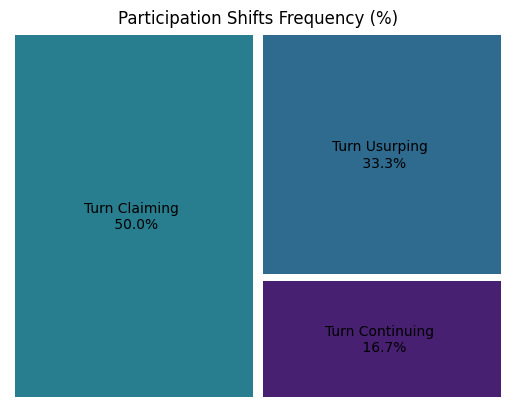

In [19]:
import squarify
import matplotlib.pyplot as plt
# import seaborn as sb
# import numpy as np

data = [el for el in list(zip(gb_pshift['Freq'].values, gb_pshift['Freq'].index.values)) if el[0]!=0 ]

lbls = [f'{el} \n {round( 100 * (list(zip(*data))[0][idx] / sum(list(list(zip(*data))[0]))),1)}%' for idx,el in enumerate(list(zip(*data))[1])]
squarify.plot(list(zip(*data))[0], label=lbls 
# ,color=sb.color_palette("Spectral", len(data))
, pad=2)
plt.axis("off")
# plt.figure(figsize=(20, 6))
plt.title('Participation Shifts Frequency (%)')
plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np


# # Some example data to display
# x = np.linspace(0, 2 * np.pi, 400)
# y = np.sin(x ** 2)

# fig, ax = plt.subplots(1, 2, figsize=(15, 7))
# ax[0].plot(x, y)
# ax[1].plot(x, -y)